# Mapping problem using moscot  
from dissociated scRNAseq data with beta cell subtype classification to spatial data 

### Import packages

In [ ]:
!pip install decoupler

In [ ]:
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [1]:
import time
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
import moscot as mt
#from moscot import datasets
from moscot.problems.space import MappingProblem
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import scanpy as sc
import squidpy as sq

### Data sets

In [2]:
adata_sc = sc.read('../../../../spatial_pancreas_data/preprocessed_data/dissociated_nd_annotation_l0.h5ad')
beta     = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/scrna/beta_subtype.h5ad')
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')

adata_sc, beta, adata_s1

(AnnData object with n_obs × n_vars = 21453 × 23146
     obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
     var: 'n_cells'
     uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors'
     obsm: 'X_pca', 'X_scVI', 'X_umap'
     layers: 'counts', 'soupX_counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 448 × 287
     obs: 'Sample', 'doublet', 'n_genes', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse', 'cell_type', 'beta1

### Subsetting and pre-processing

Subsampling to consider only Non-Diabetic slides (ND)

In [3]:
adata_sp = adata_s1[np.isin(adata_s1.obs['condition'],['ND'])].copy()
adata_sp

AnnData object with n_obs × n_vars = 61460 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [4]:
adata_sp.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

Format dissociated data

In [5]:
obs_df = adata_sc.obs
obs_df['cell_type_beta_state'] = obs_df['cell_type_coarse'].astype('category')
new_categories = pd.Categorical(['beta1','beta2'])
obs_df['cell_type_beta_state'] = obs_df['cell_type_beta_state'].cat.add_categories(new_categories)
obs_df['cell_type_beta_state'] = obs_df['cell_type_beta_state'].cat.remove_categories(['Beta'])

In [6]:
# Find the index of the observation with the given index name
for i in beta.obs['beta_subtype'].index.tolist():
    ct = beta.obs['beta_subtype'].loc[i]
    obs_df.loc[i,'cell_type_beta_state'] = ct

In [7]:
# Assign the modified DataFrame back to the `obs` field (this is optional as it's modified in place)
adata_sc.obs = obs_df
adata_sc.obs['cell_type_beta_state'].cat.categories

Index(['Acinar', 'Acinar_OLFM4+', 'Alpha', 'Delta', 'Ductal',
       'Ductal_Acinar_MUC1_AMY2A', 'Endothelial', 'Fibroblasts', 'Immune',
       'Lymphatic', 'T-cells', 'beta1', 'beta2'],
      dtype='object')

In [8]:
cluster2annotation = {
    'Alpha' : 'Alpha',
    'beta1' : 'Beta1',
    'beta2' : 'Beta2',
    'Delta' : 'Endocrine',
    'Ductal' : 'Ductal',
    'Ductal_Acinar_MUC1_AMY2A' : 'Ductal',
    'Immune' : 'Immune',
    'T-cells' : 'Immune',
    'Fibroblasts' : 'Fibroblasts',
    'Endothelial' : 'Endothelial',
    'Lymphatic' : 'Endothelial',
    'Acinar_OLFM4+' : 'Acinar', 
    'Acinar' : 'Acinar'
}

adata_sc.obs['cell_type'] = adata_sc.obs['cell_type_beta_state'].map(cluster2annotation).astype('category')

adata_sc.obs['cell_type'].cat.reorder_categories(['Acinar','Alpha','Beta1','Beta2','Ductal','Endocrine','Endothelial',
                                                         'Fibroblasts','Immune'])#,inplace=True)

AAACCCAGTGGTCTCG-1         Acinar
AAACCCATCCATCCGT-1         Acinar
AAACGAATCGAAATCC-1         Acinar
AAACGAATCGCCTAGG-1         Acinar
AAACGCTAGGCTAACG-1         Acinar
                         ...     
TTTGTTGGTGAGTAGC-1         Acinar
TTTGTTGGTGTATACC-1         Acinar
TTTGTTGGTGTCCACG-1         Acinar
TTTGTTGTCAACTGGT-1    Fibroblasts
TTTGTTGTCGTTAGAC-1         Acinar
Name: cell_type, Length: 21453, dtype: category
Categories (9, object): ['Acinar', 'Alpha', 'Beta1', 'Beta2', ..., 'Endocrine', 'Endothelial', 'Fibroblasts', 'Immune']

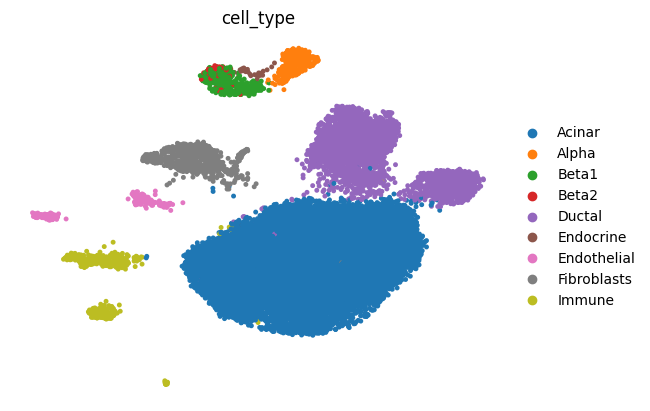

In [60]:
sc.pl.umap(adata_sc, color='cell_type', frameon=False, size=50)

In [61]:
adata_sc.obs.cell_type.value_counts()

cell_type
Acinar         15911
Ductal          3317
Fibroblasts      716
Immune           478
Beta1            378
Alpha            327
Endothelial      226
Beta2             71
Endocrine         29
Name: count, dtype: int64

In [9]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    layer='counts',
)
adata_sc

AnnData object with n_obs × n_vars = 21453 × 5000
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse', 'cell_type_beta_state', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

Pseudobulk dissociated data

In [10]:
import decoupler as dc

In [11]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata_sc,
    sample_col='Sample',
    groups_col='cell_type',
    layer='soupX_counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 24 × 5000
    obs: 'Sample', 'doublet', 'outlier', 'mt_outlier', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'psbulk_props'

In [12]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
#dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [63]:
sc.pp.neighbors(pdata)
sc.tl.umap(pdata)

In [13]:
pdata.uns['cell_type_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta1
    '#004343', #beta2
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

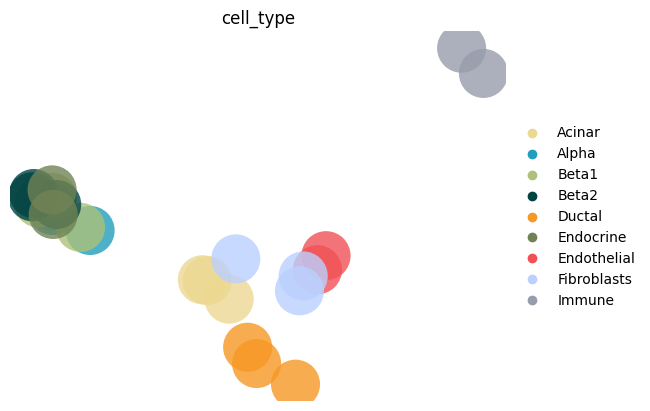

In [14]:
sc.pl.pca(pdata,color='cell_type', alpha=.8, frameon=False)

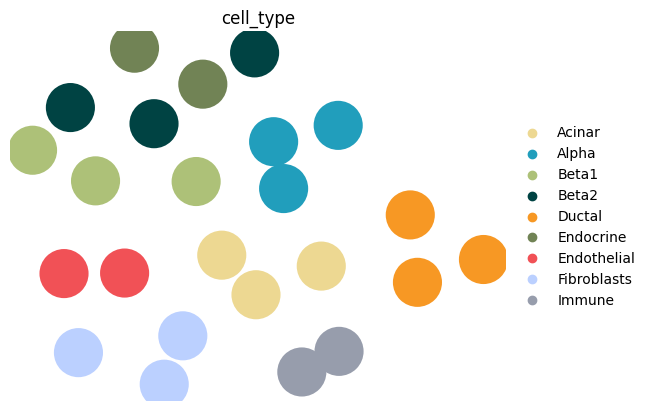

In [65]:
sc.pl.umap(pdata,color='cell_type', alpha=1, frameon=False)

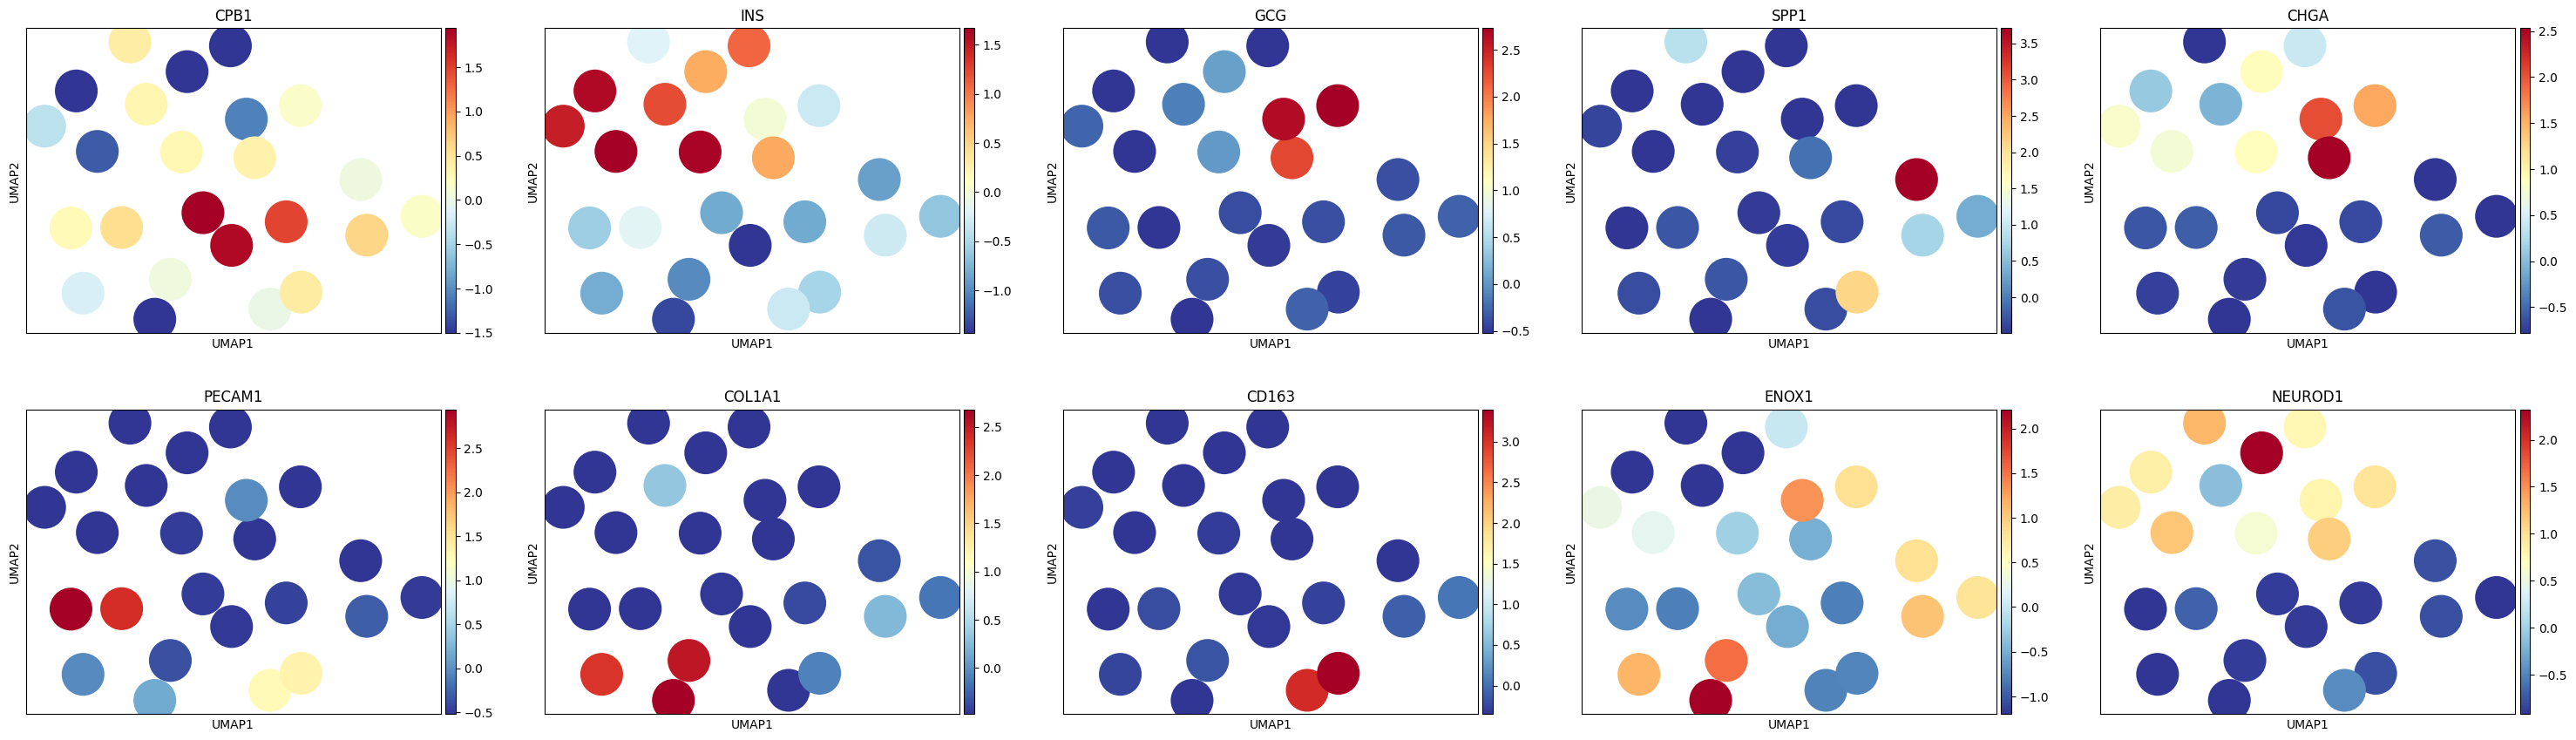

In [66]:
sc.pl.umap(pdata,color=['CPB1','INS','GCG','SPP1','CHGA','PECAM1','COL1A1','CD163','ENOX1','NEUROD1'],
          ncols=5,cmap='RdYlBu_r')

Subset to a field of view to test the mapping problem 

In [16]:
adata_sp_fov_12 = adata_sp[np.isin(adata_sp.obs['fov'],['12'])].copy()
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [17]:
sc.pp.pca(adata_sp_fov_12)
sc.pp.neighbors(adata_sp_fov_12)
sc.tl.umap(adata_sp_fov_12)

Normalization to avoid technical artifacts (has to be per fov)

### Preprare and solve the mapping problem parameter tunning

In [18]:
genes = pd.read_csv('../../../../spatial_pancreas_data/preprocessed_data/genes2impute.txt', delimiter='\t', header=None)
genes2impute = list(genes[(np.isin(genes[0],adata_sc.var_names))][0])
control_markers = pd.DataFrame(['CPB1','INS','GCG','SPP1','CHGA','PECAM1','COL1A1','CD163'])
markers2impute = list(control_markers[np.isin(control_markers,adata_sc.var_names)][0])
genes2impute = genes2impute + markers2impute

In [19]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

In [20]:
# Leave the control genes out of the fitting
adata_sp_fov_12_mp = adata_sp_fov_12[:,~adata_sp_fov_12.var_names.isin(markers2impute)].copy()

In [21]:
from sklearn.metrics import f1_score

### Analysis of the transport plan with the best set of found parameters

In [22]:
# From previous analysis --> mapping_problem_pseudobulk_v5.2_no_sp_coor.ipynb
best_param = {
    'tau_a': 0.9,
    'tau_b': 0.9,
    'alpha': 0.5,
    'epsilon': 0.1
}
best_param

{'tau_a': 0.9, 'tau_b': 0.9, 'alpha': 0.5, 'epsilon': 0.1}

In [24]:
mp = MappingProblem(adata_sc=pdata, adata_sp=adata_sp_fov_12_mp)
mp = mp.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_sp_fov_12.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
    cost = 'cosine', #'sq_euclidean', 
    joint_attr = {"attr":"X"} #'X_pca' {'attr':'X_pca'}
)
#solve mapping problem 
mp = mp.solve(alpha=best_param['alpha'],epsilon=best_param['epsilon'],tau_a=best_param['tau_a'],tau_b=best_param['tau_b'],device='cpu')

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 24)].                                            


#### Imputation

In [26]:
# impute the 5k HVG from sc data 

start_time = time.time()

adatas_imputed = []
for i in range(int(len(pdata.var_names)/20)):
    adata_imputed = mp.impute(var_names=pdata.var_names[i*20:i*20+20],device='cpu')
    adatas_imputed.append(adata_imputed)
    del adata_imputed

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 7.327356576919556 seconds


In [27]:
import anndata as ad
adata_imputed  = ad.concat(adatas_imputed, join='outer',uns_merge='same',axis=1)
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 5000

In [28]:
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [29]:
adata_imputed.uns['spatial'] = adata_sp_fov_12.uns['spatial']
adata_imputed.obsm['spatial'] = adata_sp_fov_12.obsm['spatial']
adata_imputed.obs['fov'] = adata_sp_fov_12.obs['fov']
adata_imputed.obs['cell_ID'] = adata_sp_fov_12.obs['cell_ID']  
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 5000
    obs: 'fov', 'cell_ID'
    uns: 'spatial'
    obsm: 'spatial'

Plotting imputed gene expression

In [30]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

In [31]:
correlations_hallmark_genes = []

for i in markers2impute:
    gene = i
    obs_genes = adata_sp_fov_12[:,[gene]].X.copy().toarray().flatten()
    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
    correlation, p_value = pearsonr(obs_genes, imp_genes)
    row_data = {
        'gene' : gene,
        'Pearson_correlation' : correlation,
        'P_value' : p_value
    }
    correlations_hallmark_genes.append(row_data)
                
df = pd.DataFrame(correlations_hallmark_genes)
df

gene  Pearson_correlation        P_value
0    CPB1             0.751974   0.000000e+00
1     INS             0.680720   0.000000e+00
2     GCG             0.854079   0.000000e+00
3    SPP1             0.129412   6.826339e-21
4    CHGA             0.794982   0.000000e+00
5  PECAM1             0.225490   4.975864e-61
6  COL1A1             0.386847  1.575752e-185
7   CD163             0.463855  3.089267e-276

In [ ]:
df.to_csv('../corr_moscot.csv', sep='\t', index=False)

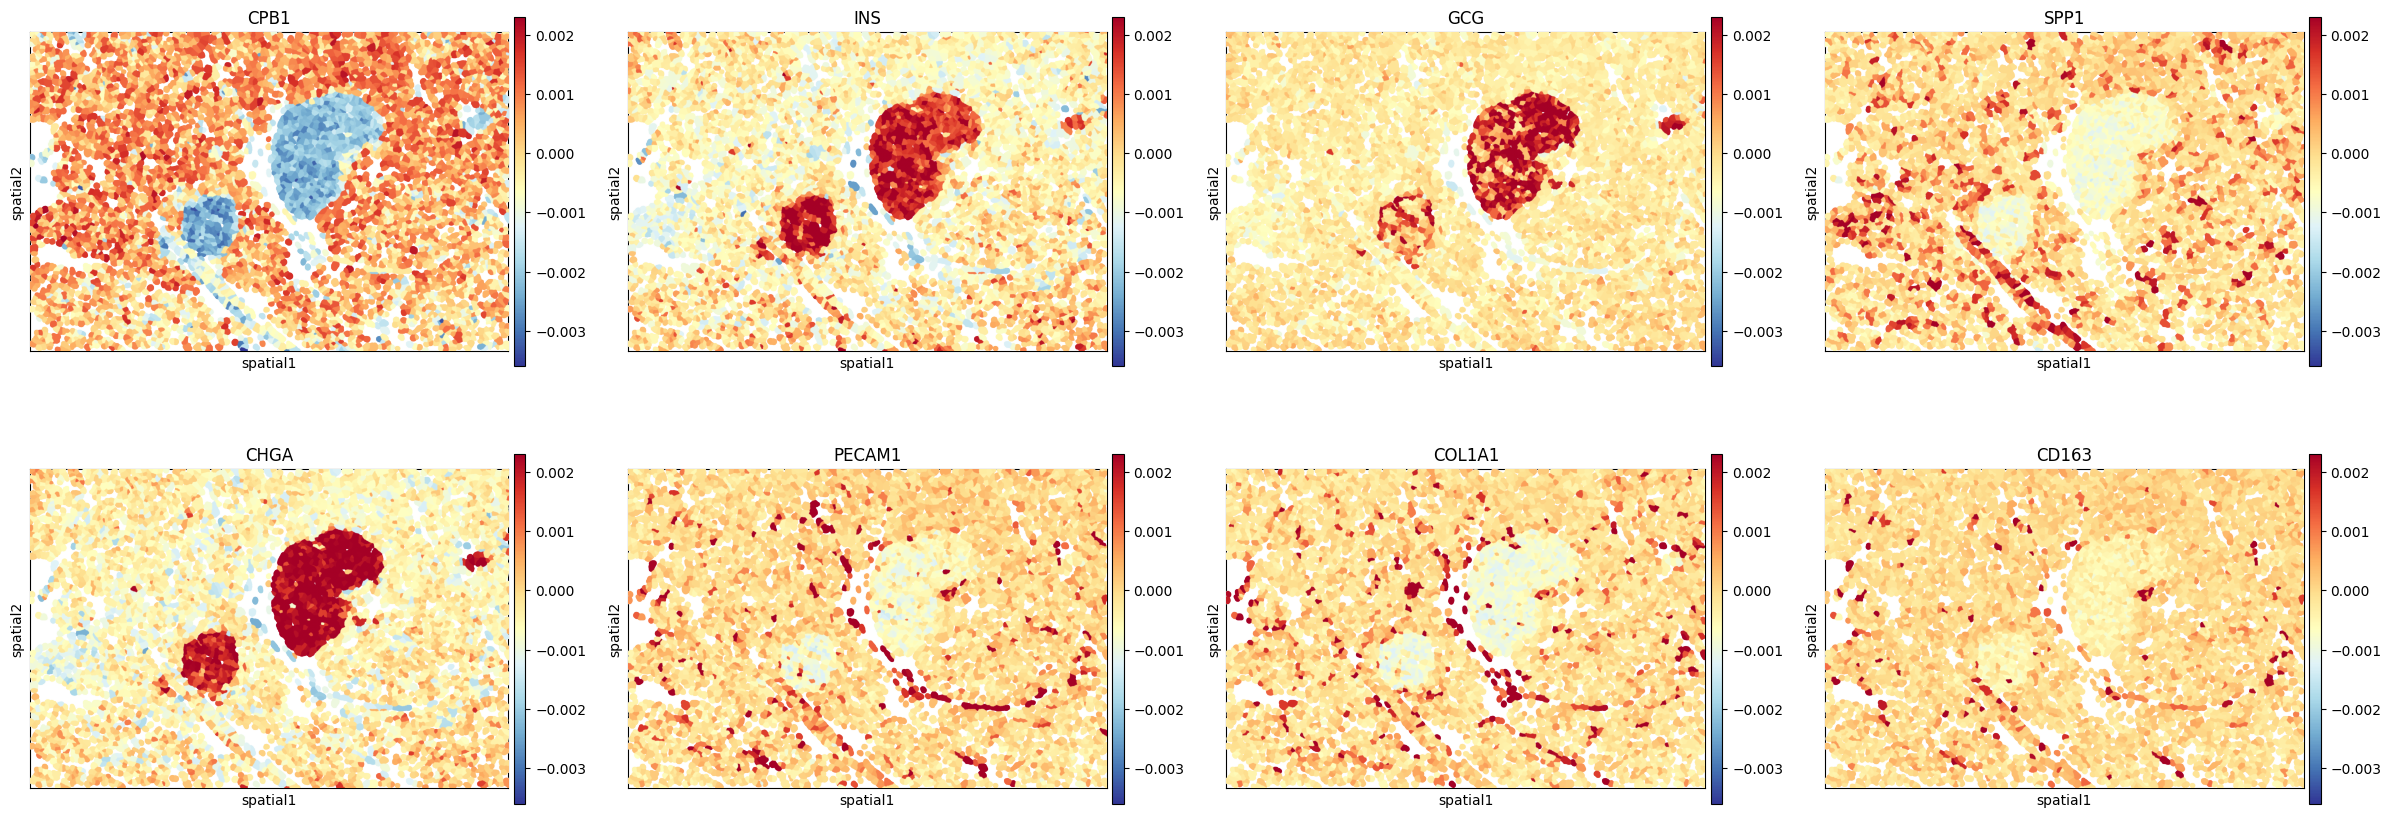

In [32]:
sq.pl.spatial_segment(adata_imputed,color=markers2impute,ncols=4,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

Plotting observed gene expression for hallmark hormone genes

In [ ]:
sq.pl.spatial_segment(adata_imputed,color=['INS','GCG','SST'],ncols=4,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [33]:
adata_imputed.obs['cell_type_coarse'] = adata_sp_fov_12.obs['cell_type_coarse']

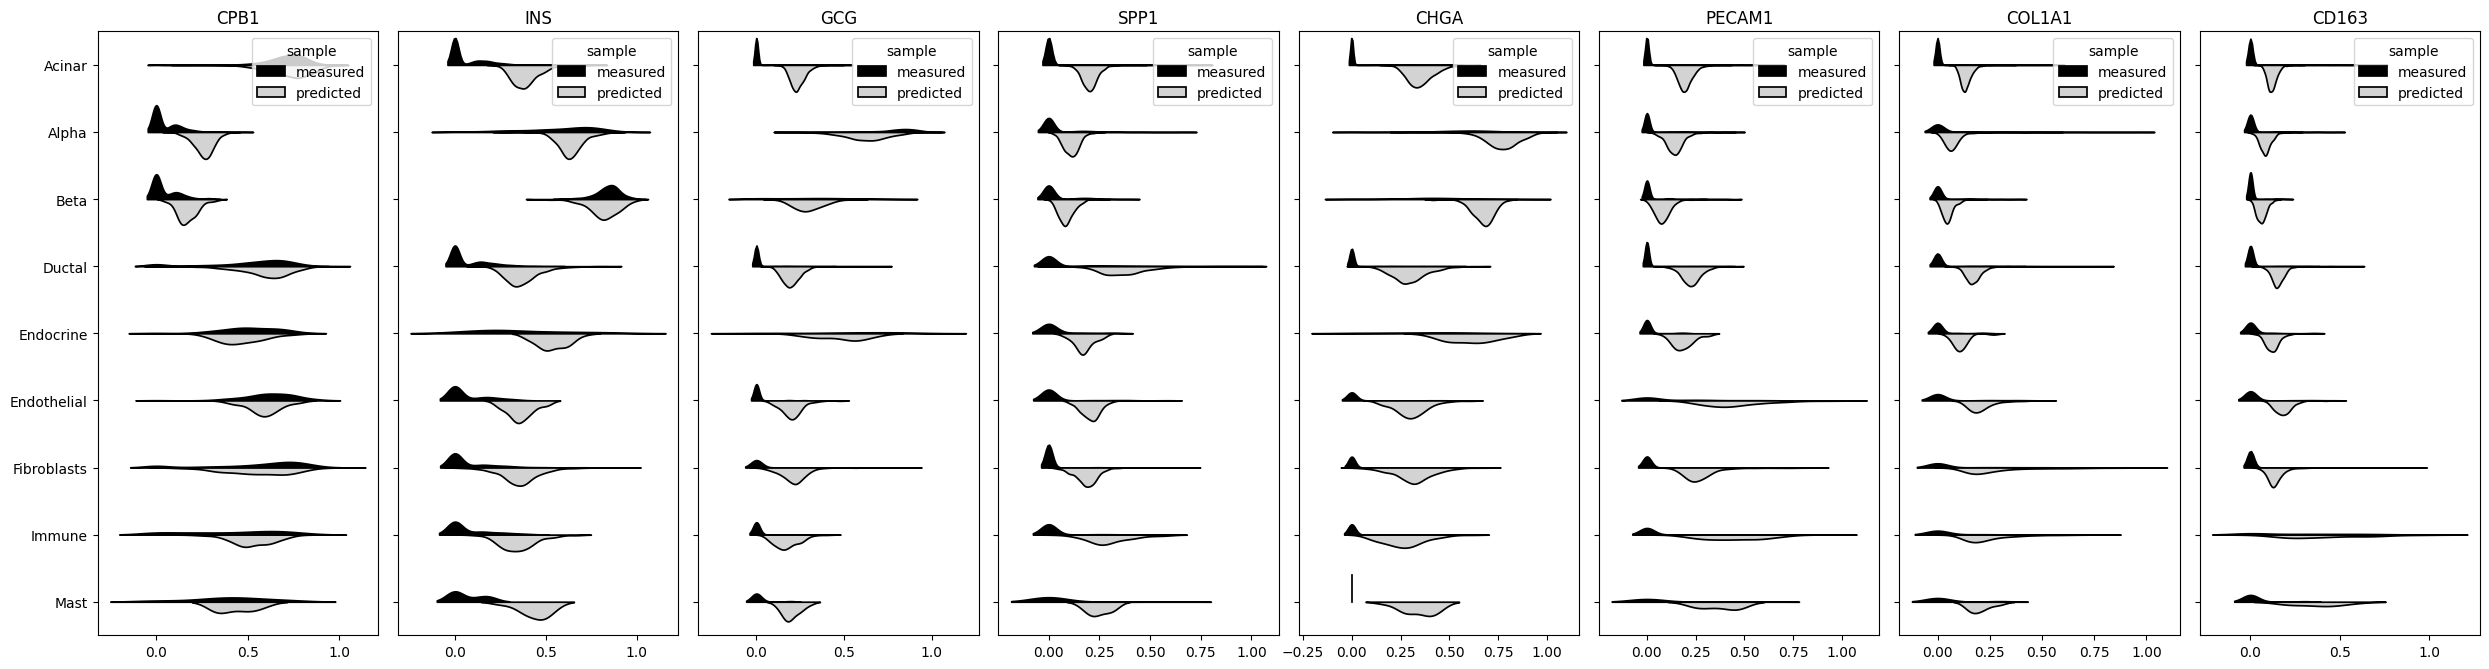

In [34]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
fig, ax = plt.subplots(1, len(markers2impute), figsize=(25, 6.8), sharey=True)

for i, marker in enumerate(markers2impute):
    # Retrieving measured counts
    measured = sc.get.obs_df(adata_sp_fov_12, [marker, "cell_type_coarse"])
    # Calculating measured expression levels
    measured["expression_level"] = (
        MinMaxScaler().fit(measured[[marker]]).transform(measured[[marker]])
    )

    # Retrieving measured counts
    predicted = sc.get.obs_df(adata_imputed, [marker, "cell_type_coarse"])
    # Calculating predicted expression levels
    predicted["expression_level"] = (
        MinMaxScaler().fit(predicted[[marker]]).transform(predicted[[marker]])
    )

    sns.violinplot(
        data=pd.concat(
            [measured, predicted], keys=["measured", "predicted"], names=["sample"]
        ).reset_index(),
        y="cell_type_coarse",
        x="expression_level",
        hue="sample",
        split=True,
        ax=ax[i],
        inner=None,
        palette={"measured": "black", "predicted": "lightgray"}
    )
    ax[i].set_title(marker)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend()
plt.tight_layout()
plt.show()

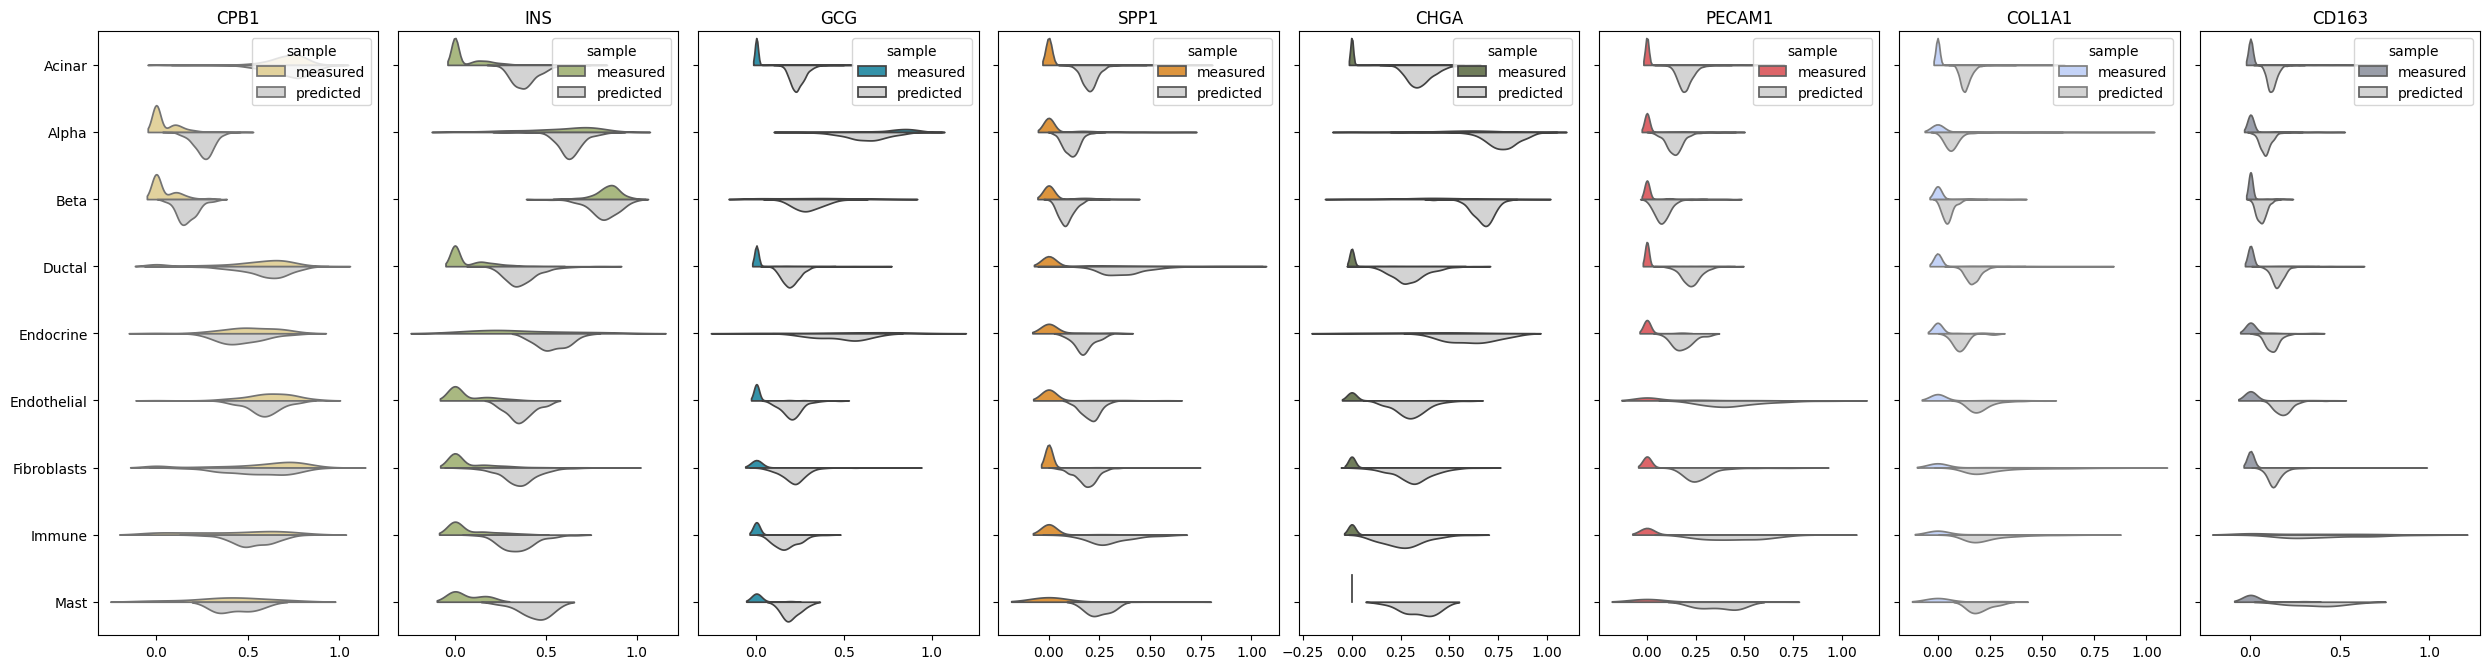

In [35]:
fig, ax = plt.subplots(1, len(markers2impute), figsize=(25, 6.8), sharey=True)

color = ['#edd892', #acinar
    '#adc178', #beta
    '#219ebc', #alpha
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac'] #Immune

for i, marker in enumerate(markers2impute):
    # Retrieving measured counts
    measured = sc.get.obs_df(adata_sp_fov_12, [marker, "cell_type_coarse"])
    # Calculating measured expression levels
    measured["expression_level"] = (
        MinMaxScaler().fit(measured[[marker]]).transform(measured[[marker]])
    )

    # Retrieving measured counts
    predicted = sc.get.obs_df(adata_imputed, [marker, "cell_type_coarse"])
    # Calculating predicted expression levels
    predicted["expression_level"] = (
        MinMaxScaler().fit(predicted[[marker]]).transform(predicted[[marker]])
    )

    sns.violinplot(
        data=pd.concat(
            [measured, predicted], keys=["measured", "predicted"], names=["sample"]
        ).reset_index(),
        y="cell_type_coarse",
        x="expression_level",
        hue="sample",
        split=True,
        ax=ax[i],
        inner=None,
        palette={"measured": color[i], "predicted": "lightgray"}
    )
    ax[i].set_title(marker)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend()
plt.tight_layout()
plt.show()

#### Annotation mapping

In [36]:
mp[("src", "tgt")]

OTProblem[stage='solved', shape=(5208, 24)]

In [37]:
type(pdata.obs.cell_type)

pandas.core.series.Series

In [38]:
pdata.obs.cell_type = pdata.obs.cell_type.astype("category")

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [ ]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=1.0
%env XLA_PYTHON_CLIENT_ALLOCATOR=cub

Annotation mapping using “max” mode

In [39]:
start_time = time.time()

anno_map_max = mp.annotation_mapping(
    "max",
    "cell_type",
    source="src",
    #target="tgt",
    forward=False,
    batch_size=256,
)

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 3.2066314220428467 seconds


In [40]:
adata_sp_fov_12.obs["cell_type_max"] = anno_map_max["cell_type"].values
adata_sp_fov_12.obs["cell_type_max"] = adata_sp_fov_12.obs["cell_type_max"].astype("category")

In [41]:
adata_sp_fov_12.uns['cell_type_max_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta1
    '#004343', #beta2
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

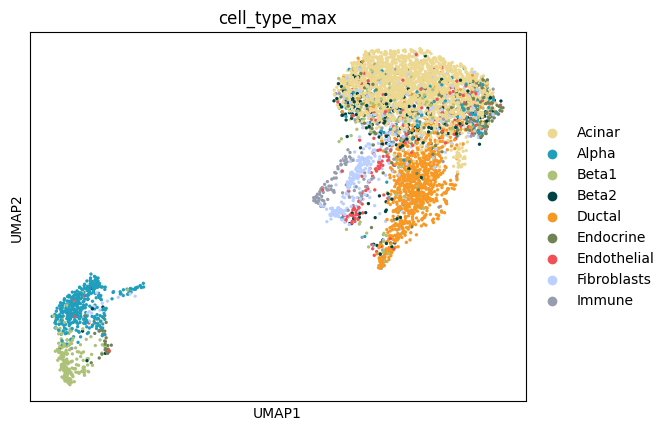

In [42]:
#sc.pl.umap(adata_sc, color="cell_type")
sc.pl.umap(adata_sp_fov_12, color=["cell_type_max"])

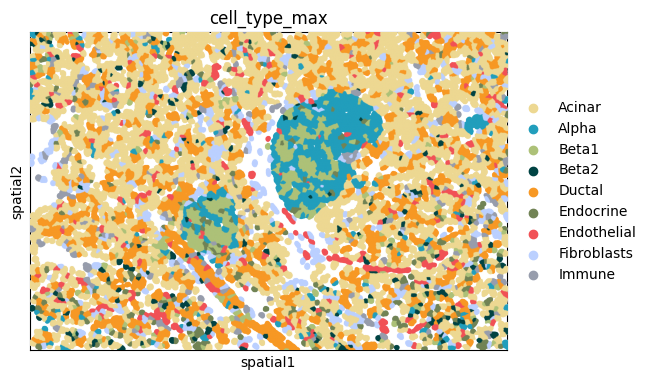

In [43]:
sq.pl.spatial_segment(adata_sp_fov_12,color='cell_type_max',size=5,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

Annotation mapping using the “sum” mode

In [44]:
anno_map_sum = mp.annotation_mapping(
    "sum",
    "cell_type",
    source="src",
    forward=False,
    batch_size=256,
)
adata_sp_fov_12.obs["cell_type_sum"] = anno_map_sum["cell_type"].values
adata_sp_fov_12.obs["cell_type_sum"] = adata_sp_fov_12.obs["cell_type_sum"].astype("category")

In [45]:
adata_sp_fov_12.uns['cell_type_sum_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta1
    '#004343', #beta2
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
]

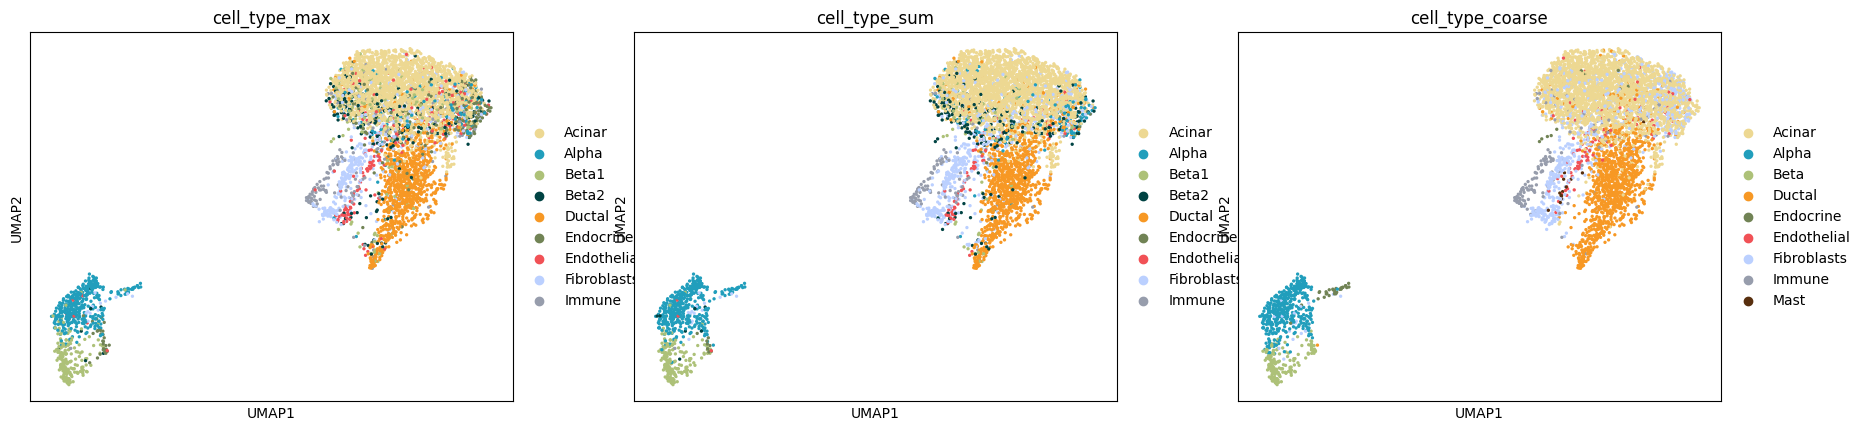

In [46]:
sc.pl.umap(adata_sp_fov_12, color=["cell_type_max", "cell_type_sum","cell_type_coarse"])

In [47]:
adata_sp_fov_12[adata_sp_fov_12.obs["cell_type_max"] == adata_sp_fov_12.obs["cell_type_sum"]].shape[
    0
] / adata_sp_fov_12.shape[0]

0.8600230414746544

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
y_true = np.array(adata_sp_fov_12_cmp.obs["cell_type_coarse"])
y_pred = np.array(adata_sp_fov_12_cmp.obs["cell_type_sum"])

f1 = f1_score(y_true, y_pred, average = 'weighted')

print("F1 score:", f1)

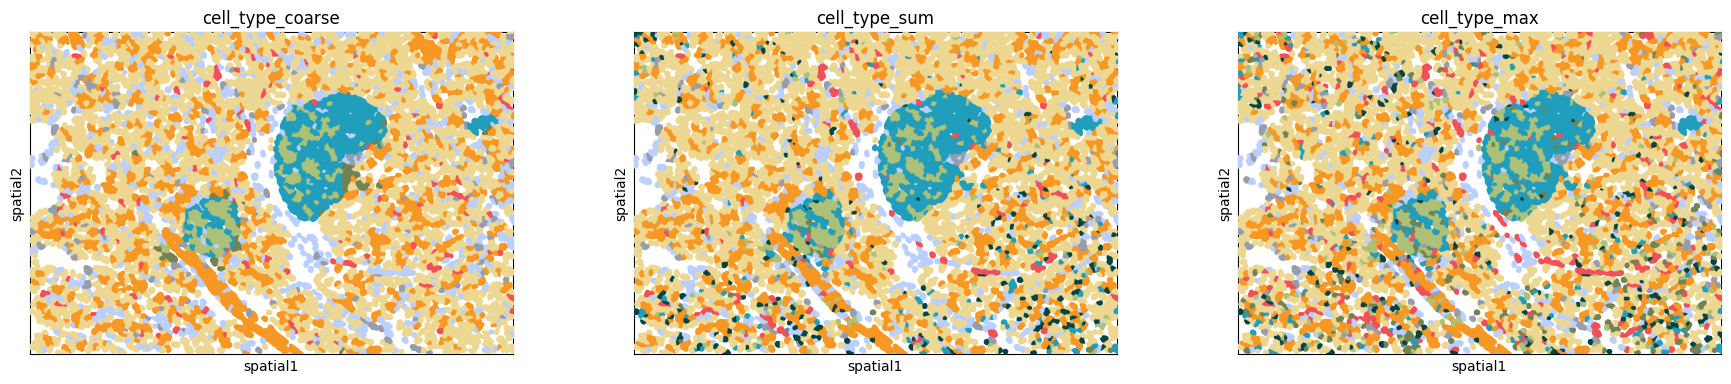

In [52]:
sq.pl.spatial_segment(adata_sp_fov_12_cmp,color=['cell_type_coarse','cell_type_sum','cell_type_max'],size=.2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False,legend_loc=None)

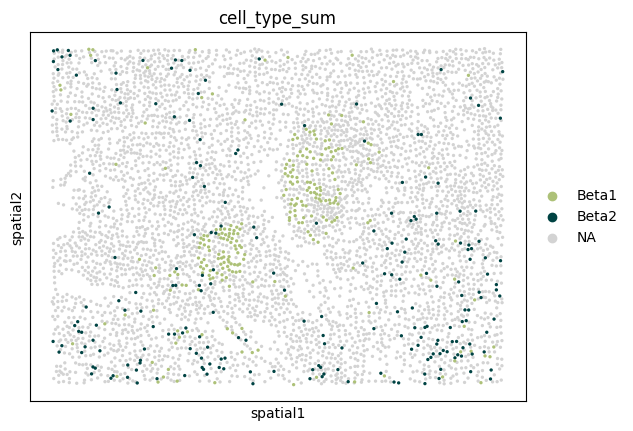

In [59]:
sc.pl.embedding(adata_sp_fov_12_cmp,color=['cell_type_sum'],groups=['Beta1','Beta2'],
                      basis='spatial')